<a href="https://colab.research.google.com/github/Hemanjali04/Hardware-for-AI-ML/blob/main/Week%204%20Challenges/Challenge%2013/GPU_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
N=32768, Time(ms)=7.669536
N=65536, Time(ms)=0.002400
N=131072, Time(ms)=0.002720
N=262144, Time(ms)=0.002688
N=524288, Time(ms)=0.003040
N=1048576, Time(ms)=0.002880
N=2097152, Time(ms)=0.002912
N=4194304, Time(ms)=0.003200
N=8388608, Time(ms)=0.002848
N=16777216, Time(ms)=0.002848
N=33554432, Time(ms)=0.002848



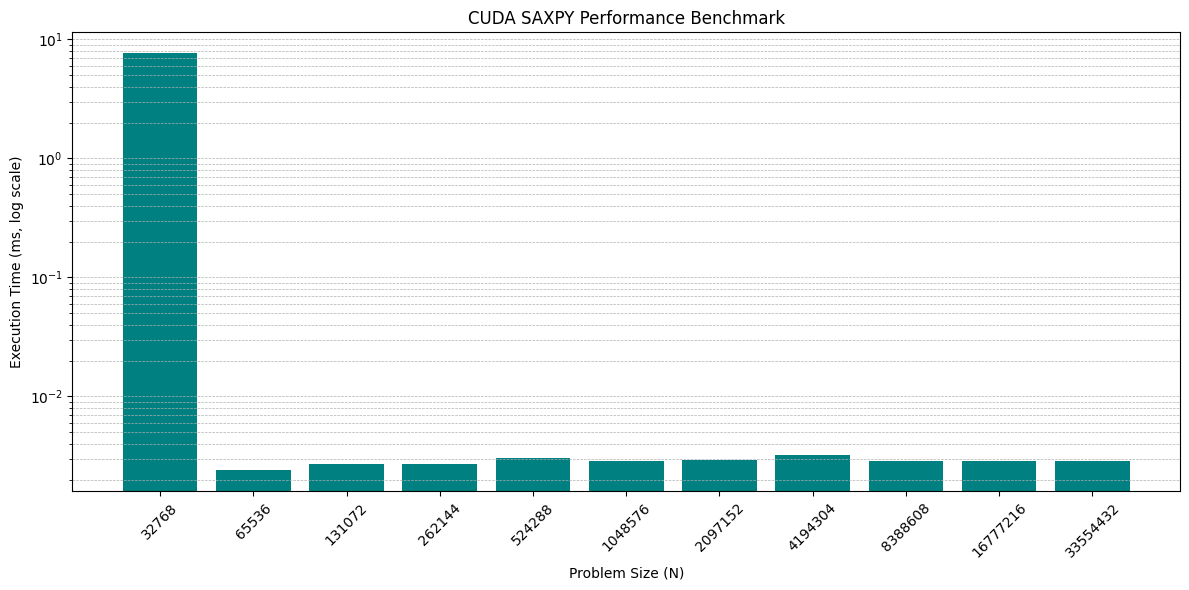

In [5]:
# Step 1: Check CUDA compiler availability
!nvcc --version

# Step 2: Save the CUDA SAXPY benchmark code
cuda_code = r'''
#include <stdio.h>
#include <cuda.h>

__global__
void saxpy(int n, float a, float *x, float *y) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = a * x[i] + y[i];
}

int main() {
    int sizes[] = {32768, 65536, 131072, 262144, 524288, 1048576, 2097152,
                   4194304, 8388608, 16777216, 33554432};
    int num_sizes = sizeof(sizes) / sizeof(sizes[0]);

    for (int idx = 0; idx < num_sizes; ++idx) {
        int N = sizes[idx];

        float *x, *y, *d_x, *d_y;
        x = (float*)malloc(N * sizeof(float));
        y = (float*)malloc(N * sizeof(float));

        for (int i = 0; i < N; i++) {
            x[i] = 1.0f;
            y[i] = 2.0f;
        }

        cudaMalloc(&d_x, N * sizeof(float));
        cudaMalloc(&d_y, N * sizeof(float));

        cudaMemcpy(d_x, x, N * sizeof(float), cudaMemcpyHostToDevice);
        cudaMemcpy(d_y, y, N * sizeof(float), cudaMemcpyHostToDevice);

        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);
        cudaEventRecord(start);

        saxpy<<<(N + 255) / 256, 256>>>(N, 2.0f, d_x, d_y);

        cudaEventRecord(stop);
        cudaEventSynchronize(stop);
        float milliseconds = 0;
        cudaEventElapsedTime(&milliseconds, start, stop);

        printf("N=%d, Time(ms)=%.6f\n", N, milliseconds);

        cudaFree(d_x);
        cudaFree(d_y);
        free(x);
        free(y);
    }
    return 0;
}
'''

with open("saxpy_benchmark.cu", "w") as f:
    f.write(cuda_code)

# Step 3: Compile the code
!nvcc saxpy_benchmark.cu -o saxpy_benchmark

# Step 4: Run the binary and capture output
import subprocess
result = subprocess.run(["./saxpy_benchmark"], capture_output=True, text=True)
print(result.stdout)

# Step 5: Parse the output
import matplotlib.pyplot as plt

lines = result.stdout.strip().split('\n')
sizes = []
times = []

for line in lines:
    if "N=" in line:
        parts = line.strip().split(',')
        N = int(parts[0].split('=')[1].strip())
        t = float(parts[1].split('=')[1].strip())
        sizes.append(N)
        times.append(t)

# Step 6: Plot with log scale
plt.figure(figsize=(12, 6))
plt.bar([str(s) for s in sizes], times, color='teal')

plt.xlabel("Problem Size (N)")
plt.ylabel("Execution Time (ms, log scale)")
plt.title("CUDA SAXPY Performance Benchmark")
plt.yscale('log')  # Log scale for small values
plt.xticks(rotation=45)
plt.grid(True, which="both", axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
